### Собственно что это?

Будем пытаться разобраться и написать для себя какие-то очерки для хорошего понимания

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import kagglehub
import idx2numpy
import os

### Загрузка данных

In [16]:
def read_mnist():
    path = kagglehub.dataset_download("hojjatk/mnist-dataset")
    print("Путь до данных:", path)

    train_images_path = os.path.join(path, 'train-images.idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels.idx1-ubyte')
    test_imaages_path = os.path.join(path, 't10k-images.idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels.idx1-ubyte')
    
    X_train = idx2numpy.convert_from_file(train_images_path)
    y_train = idx2numpy.convert_from_file(train_labels_path)
    X_test = idx2numpy.convert_from_file(test_imaages_path)
    y_test = idx2numpy.convert_from_file(test_labels_path)

    print(f'Загружено тренировочных картинток: {len(X_train)}')
    print(f'Загружено тренировочных меток: {len(y_train)}')
    print(f'Загружено тестовых картинток: {len(X_test)}')
    print(f'Загружено тестовых меток: {len(y_test)}')
    
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = read_mnist()

Путь до данных: C:\Users\panika\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1
Загружено тренировочных картинток: 60000
Загружено тренировочных меток: 60000
Загружено тестовых картинток: 10000
Загружено тестовых меток: 10000


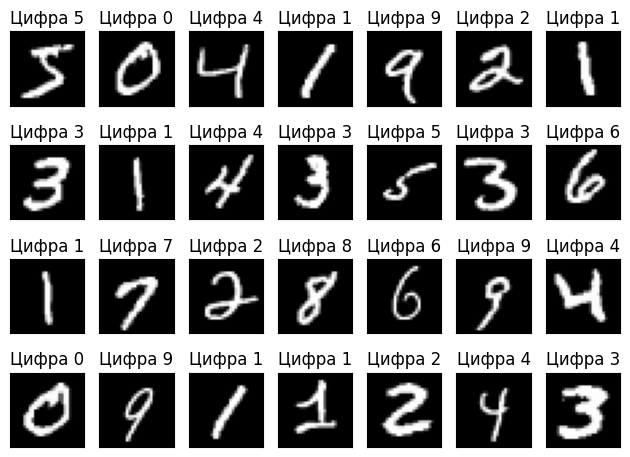

In [117]:
fig, axs = plt.subplots(4, 7)
ii = 0
for ax_row in axs:
    for ax in ax_row:
        ax.imshow(X_train[ii], cmap='grey')
        ax.set_title(f'Цифра {y_train[ii]}')
        ax.set_xticks([])
        ax.set_yticks([])
        ii += 1

plt.tight_layout()
plt.show()

## Прямой процесс диффузиии

Пусть данные нормализованы $x_t \in [-1,1]$, $\varepsilon$ ~ $N[0, I]$

$q(x_t|x_{t-1}) = N(\sqrt{1-\beta_t}x_{t-1}; \beta_tI)$

$x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\varepsilon$

Написать про матожидание, про дисперсию, про границы и сумма двух с.в.


Для начала поймем, что вся работа идет с тензорами - это многомерный прямоуголник с элементами \[n, m, k, h]. Тензор который юзается будет выглядеть в виде \[Батч, Количество каналов, Размер по H, размер по W]. Таким образом, любой входной элемент для функций будет иметь именно такой вид

In [106]:
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

In [81]:
def q_sample(x_start, t, alphas_cumprod, noise):  
    """
    Add noise to x_start
    Args:
        x_start: [Batch, canals, W, H]
        t: [B,]
        alphas_cumprod: array of alphas
        noise: [Batch, canals, W, H] ~ N(0, I)
    """
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def time_embedding(t, dim):
    """
    n = dim
    t -> {sin(w1*t), cos(w1*t), ... sin(wn*t), cos(wn*t)}
    Args:
        t: [B, ]
        dim: scalar
    """
    idx = torch.arange(0, dim // 2, device=t.device)
    w = 1 / (10000 ** ((2 * idx) / dim))
    angles = t[:, None] * w[None, :]
    sin = torch.sin(angles)
    cos = torch.cos(angles)
    return torch.cat([sin, cos], dim=-1)

## Обратный процесс диффузии

Основной идеей является использование U-net. Архитектурно происходит процесс сжатия картинки и увеличения каналов. Это решение имеет преимущество над обычной сверткой без сжатия тем, что при обычном свертке проходясь ядром некоторые пиксели не видят друг друга, то есть не дотрагиваются при малом количестве сверток, а при большом слишком много параметров получается.

Время отображается в вектор длины каналов так, что это отображение является биекцией. После добалвяется как смещение. Это решение принято, потому что при таком подмешивании времени нейронка вполне точно осознает, что смешалось время, потому что картинки имеющие разного уровня шум имеют разное смещение. То есть картинки с одиниковым уровнем скапливаются у одной области в $\mathbb R^n$

Архитектура U-net имеет skip-connections. Если представить что картинка сжимается вниз, то это соединения справа и слева. Это обусловлено тем, что некоторые картинки могут быть не сильно зашумлены и такое соединение передает некую хорошую долю информации у не сильно зашумленных картинках

...Gemeni

Про биекцию: Строго говоря, нам не нужна математическая биекция (хотя она получается), нам нужна уникальность. Каждое t должно давать уникальный вектор смещения, чтобы сеть не перепутала шаг 100 и шаг 200.

Про Skip-connections: Они важны не только для «не сильно зашумленных» картинок. Даже при сильном шуме они передают «скелет» изображения (крупные пятна), который теряется при сжатии в 7x7. Это позволяет сети не галлюцинировать цифру в случайном месте, а привязывать её к тем признакам, что были в оригинале.

...

? Block - это часть которая осознает и обрабатывает, а за уменьшение размера изображения отвечают другие фукнкции

? Время в диффузионках дается нелинейно, из-за этого идет аналогия нелинейного смещивание

? Здесь находится какой-то диффур (так Миша сказал), который можно решить

? if x.shape[1] == h.shape[1]: return x + h - вот это штука помогает сходиться методу лучше, так как напрямую связано с неявным методом Эйлера. А все же кажется небольшим костылем, потому что при поднятии навверх он не используется

In [82]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t_emb):
        h = self.relu(self.conv1(x))
        h = h + self.time_mlp(t_emb).view(t_emb.shape[0], -1, 1, 1)
        h = self.relu(self.conv2(h))

        if x.shape[1] == h.shape[1]:
            return x + h
        return h


class Unet(nn.Module):
    def __init__(self, time_dim):
        super().__init__()
        self.time_dim = time_dim
        self.init_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        self.down1 = Block(64, 64, time_dim)
        self.to_128 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        self.down2 = Block(128, 128, time_dim)
        self.to_256 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        self.bottleneck = Block(256, 256, time_dim)
        
        self.up_to_14 = nn.Upsample(scale_factor=2, mode='bilinear')

        self.up_block1 = Block(384, 128, time_dim)
        
        self.up_to_28 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up_block2 = Block(192, 64, time_dim)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        t_emb = time_embedding(t, self.time_dim)

        x = self.init_conv(x) 
        
        s1 = self.down1(x, t_emb)      # [B, 64, 28, 28]
        x = self.to_128(s1)            # [B, 128, 14, 14]
        
        s2 = self.down2(x, t_emb)      # [B, 128, 14, 14]
        x = self.to_256(s2)            # [B, 256, 7, 7]
        
        x = self.bottleneck(x, t_emb)  # [B, 256, 7, 7]
        
        x = self.up_to_14(x)           # [B, 256, 14, 14]
        x = torch.cat([x, s2], dim=1)  # [B, 384, 14, 14] (256 + 128)
        x = self.up_block1(x, t_emb)   # [B, 128, 14, 14]
        
        x = self.up_to_28(x)           # [B, 128, 28, 28]
        x = torch.cat([x, s1], dim=1)  # [B, 192, 28, 28] (128 + 64)
        x = self.up_block2(x, t_emb)   # [B, 64, 28, 28]
        
        return self.final_conv(x)      # [B, 1, 28, 28]

### Нормализация и подготовка данных

In [83]:
X_train.shape

(60000, 28, 28)

In [84]:
def normalize_data(X):
    X_zero_one = X / 255.0
    X_minus_one_one = (X_zero_one - 0.5) * 2.0
    return X_minus_one_one

batch_size = 128
X = torch.tensor(X_train, dtype=torch.float32)
X_norm = normalize_data(X)a
X_batch = X_norm.view(-1, 1, 28, 28)
train_loader = DataLoader(TensorDataset(X_batch), batch_size=batch_size, shuffle=True)

### Обучение

In [ ]:
def show_epoch_loss(losses, count):
    x = np.arange(0, count)
    plt.plot(x, losses, linestyle='--', color='red', linewidth=1.1)
    plt.scatter(x, losses, color='blue')
    plt.xlim((-0.3, np.max(losses)))
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, count + 1))
    plt.grid(alpha=0.7)
    plt.show()

In [113]:
%%time

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(time_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 20

alphas_cumprod_tensor = alphas_cumprod.to(device)

# epoch_losses = [0] * epochs
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        x0 = batch[0].to(device)

        t = torch.randint(0, timesteps, (x0.shape[0],), device=device)
        real_noise = torch.randn_like(x0).to(device)
        
        xt = q_sample(x0, t, alphas_cumprod_tensor, real_noise)
        
        predicted_noise = model(xt, t)
        
        loss = torch.nn.functional.mse_loss(predicted_noise, real_noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    torch.cuda.synchronize()
    print(f'Эпоха {epoch}: Loss MSE: {epoch_loss / len(train_loader)}')
    # epoch_losses[epoch] = epoch_loss / len(train_loader)
    # show_epoch_loss(epoch_losses, epochs)

Эпоха 0: Loss MSE: 0.11962718926449574
Эпоха 1: Loss MSE: 0.03936025435958844
Эпоха 2: Loss MSE: 0.03385190571993907
Эпоха 3: Loss MSE: 0.03125872104359207
Эпоха 4: Loss MSE: 0.029911514804529738
Эпоха 5: Loss MSE: 0.02856707022483669
Эпоха 6: Loss MSE: 0.027833601801411936
Эпоха 7: Loss MSE: 0.027350942570485794
Эпоха 8: Loss MSE: 0.02648280755972176
Эпоха 9: Loss MSE: 0.026090222738508476
Эпоха 10: Loss MSE: 0.02547062189975527
Эпоха 11: Loss MSE: 0.025137936394574293
Эпоха 12: Loss MSE: 0.025055754266536313
Эпоха 13: Loss MSE: 0.025303895972462607
Эпоха 14: Loss MSE: 0.02457679418136062
Эпоха 15: Loss MSE: 0.024272762926053137
Эпоха 16: Loss MSE: 0.024406485742073197
Эпоха 17: Loss MSE: 0.02389438466619708
Эпоха 18: Loss MSE: 0.023791839875010795
Эпоха 19: Loss MSE: 0.02385219252074578
CPU times: total: 17min 20s
Wall time: 16min 51s


### Генерация

Отдельным пунктом, которую стоит отметить, является генерация. Процесс генерации - это постепенный итеративный процесс снятия шума от $T$ до 0, то есть мы постепенно снимаем шум, что позволяет (?).  

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sqrt_inv_alphas = 1 / torch.sqrt(alphas)
coeff = (1 - alphas) / torch.sqrt(1 - alphas_cumprod)

@torch.no_grad()
def generate_digit(model):
    model.eval()
    img = torch.randn((20, 1, 28, 28), device=device)
    
    for t_idx in reversed(range(timesteps)):
        t_tensor = torch.tensor([t_idx], device=device)
        
        pred_noise = model(img, t_tensor)
        img = sqrt_inv_alphas[t_idx] * (img - coeff[t_idx] * pred_noise)
        
        if t_idx > 0:
            z = torch.randn_like(img)
            img = img + torch.sqrt(betas[t_idx]) * z
            
    img = (img.clamp(-1, 1) + 1) / 2
    return img.cpu().numpy().squeeze()

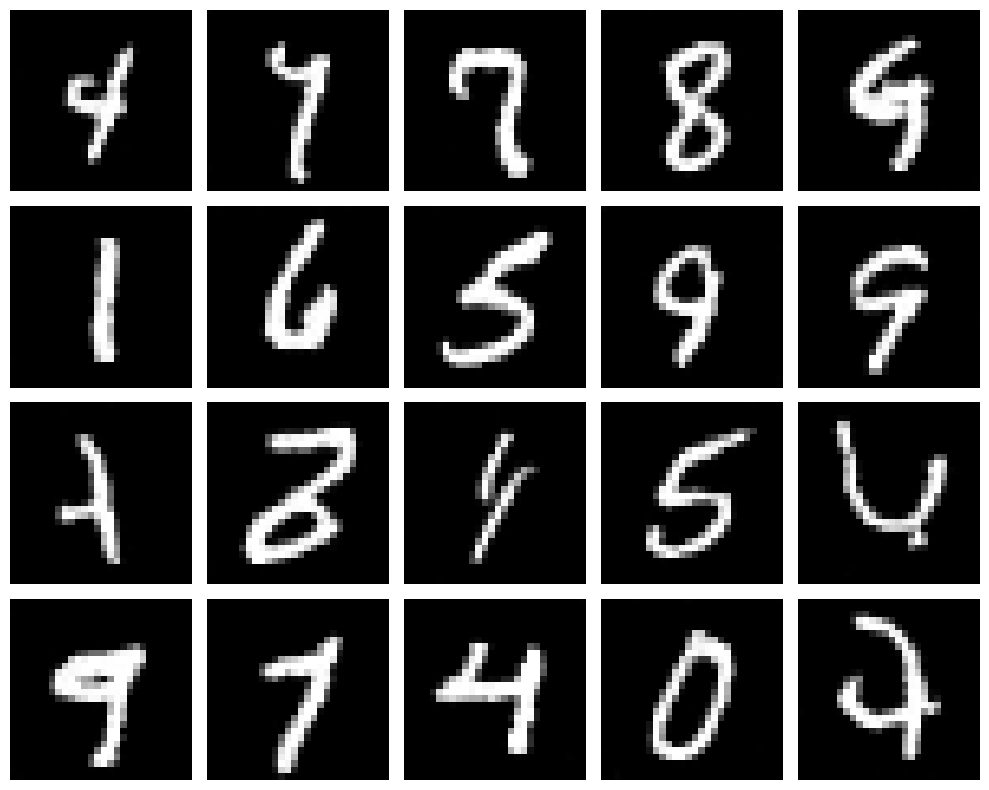

In [115]:
generated_imgs = generate_digit(model)

fig, axs = plt.subplots(4, 5, figsize=(10, 8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(generated_imgs[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Приложение